In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

import torchvision.transforms as transforms
from torchvision.io import read_image
from torchsummary import summary

from IPython.display import Image as show_image
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import time
from PIL import Image
from sklearn.model_selection import train_test_split

import pandas as pd

In [3]:
os.chdir('..')
os.chdir('..')
os.chdir('dogs/Images')

# CNN Design Notes

## Strategy

* Use Dan's CNN to start
* Likewise, begin with greyscale

## Questions

* How to sample data?
* Seperate into train, validate and test. Possibly 70:15:15
* Should each breed be proportional in each set, or should I sample randomly?

## Pre-process data

* Create dataset 
* Dog images are stored in images/breed_dir/
* Labels can be taken from breed_dir or alternately from corresponding annotations/breed_dir/

In [4]:
# Save annotations/labels to file

labels = ['Chihuahua']
image_path = []
label_num = []

label_count = 0
for root, dirs, files in os.walk("."):
    for name in files:
#         print(os.path.join(root, name))
#         print(root.split("-",1)[1])
        
        labels.append(root.split("-",1)[1])
        image_path.append(os.path.join(root, name))
        
        if labels[-1] != labels[-2]:
            label_count += 1
        
        label_num.append(label_count)
        

df = pd.DataFrame({'labels':labels[1:],'image_path':image_path, 'label_num':label_num}) 

# Create label dict for later use
breeds = pd.Series(df.labels.values,index=df.label_num).to_dict()

# saving the dataframe 
df.to_csv('../../experiments/felix/annotations.csv') 
display(df.head())
display(df.tail())

,labels,image_path,label_num
0,Chihuahua,./n02085620-Chihuahua/n02085620_10621.jpg,0
1,Chihuahua,./n02085620-Chihuahua/n02085620_10976.jpg,0
2,Chihuahua,./n02085620-Chihuahua/n02085620_11238.jpg,0
3,Chihuahua,./n02085620-Chihuahua/n02085620_11258.jpg,0
4,Chihuahua,./n02085620-Chihuahua/n02085620_11337.jpg,0


,labels,image_path,label_num
20575,French_bulldog,./n02108915-French_bulldog/n02108915_6142.jpg,119
20576,French_bulldog,./n02108915-French_bulldog/n02108915_623.jpg,119
20577,French_bulldog,./n02108915-French_bulldog/n02108915_9666.jpg,119
20578,French_bulldog,./n02108915-French_bulldog/n02108915_971.jpg,119
20579,French_bulldog,./n02108915-French_bulldog/n02108915_9899.jpg,119


In [5]:
# Test annotations
doggo_annotations = pd.read_csv("../../experiments/felix/annotations.csv")
index = 400
print("Index: ", doggo_annotations.iloc[index, 0], "\nLabel: ", doggo_annotations.iloc[index, 1], "\nImage directory: ", doggo_annotations.iloc[index, 2], "\nLabel number: ", doggo_annotations.iloc[index, 3])

print("\nTotal number of samples: ", doggo_annotations.shape[0], "\nDog breeds/ unique labels: ", len(pd.unique(doggo_annotations['labels'])))

# print("\nBreed value counts:", doggo_annotations['labels'].value_counts())

print("\nNumber images per breed \nMax: ", max(doggo_annotations['labels'].value_counts()), "\nMin:", min(doggo_annotations['labels'].value_counts()))


Index:  400 
Label:  Maltese_dog 
Image directory:  ./n02085936-Maltese_dog/n02085936_426.jpg 
Label number:  2

Total number of samples:  20580 
Dog breeds/ unique labels:  120

Number images per breed 
Max:  252 
Min: 148


In [6]:
# Create train, validate and test with proportional classes

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

label_num = np.array(doggo_annotations.iloc[:, 3])

# labels
dataY = label_num

# features
dataX_dummy = range(len(label_num)) 

# train is now 75% of the entire data set
index_train, index_test, y_train, y_test = train_test_split(dataX_dummy, dataY, test_size=1 - train_ratio, stratify=dataY)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
index_val, index_test, y_val, y_test = train_test_split(index_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test) 

In [7]:
# Check indices work
img_annotations = pd.read_csv("../../experiments/felix/annotations.csv").iloc[index_train]
display(img_annotations.head())
print(img_annotations.iloc[0,2])
print(img_annotations.iloc[1,2])

,Unnamed: 0,labels,image_path,label_num
17936,17936,Pomeranian,./n02112018-Pomeranian/n02112018_14468.jpg,103
16353,16353,Siberian_husky,./n02110185-Siberian_husky/n02110185_2941.jpg,95
5027,5027,American_Staffordshire_terrier,./n02093428-American_Staffordshire_terrier/n02...,27
20059,20059,English_foxhound,./n02089973-English_foxhound/n02089973_2681.jpg,116
15345,15345,bull_mastiff,./n02108422-bull_mastiff/n02108422_1166.jpg,89


./n02112018-Pomeranian/n02112018_14468.jpg
./n02110185-Siberian_husky/n02110185_2941.jpg


In [8]:
class DoggoDataset(Dataset):
    def __init__(self, indices, transform=None):
        self.img_annotations = pd.read_csv("../../experiments/felix/annotations.csv").iloc[indices]
        self.transform = transforms.Compose([transforms.Resize((120,120)),transforms.Grayscale(),transforms.ToTensor()])
#         self.transform = transforms.Compose([transforms.Resize((120,120)),transforms.Grayscale(),transforms.ToTensor()])

    def __len__(self):
        return len(self.img_annotations)

    def __getitem__(self, idx):
        img_path = self.img_annotations.iloc[idx, 2]
        image = Image.open(img_path)
        label = self.img_annotations.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

***** Train ***** 

0 torch.Size([1, 120, 120])
1 torch.Size([1, 120, 120])
2 torch.Size([1, 120, 120])
3 torch.Size([1, 120, 120])


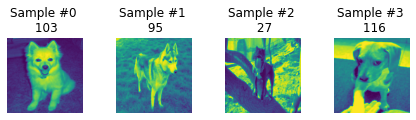

***** Validation ***** 

0 torch.Size([1, 120, 120])
1 torch.Size([1, 120, 120])
2 torch.Size([1, 120, 120])
3 torch.Size([1, 120, 120])


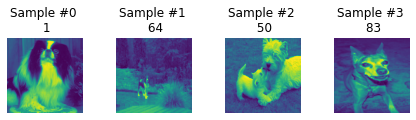

***** Test ***** 

0 torch.Size([1, 120, 120])
1 torch.Size([1, 120, 120])
2 torch.Size([1, 120, 120])
3 torch.Size([1, 120, 120])


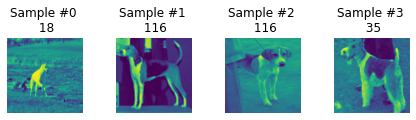

In [9]:
train_set = DoggoDataset(index_train)
val_set = DoggoDataset(index_val)
test_set = DoggoDataset(index_test)


train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)


def dataset_sample(dataset):
    for i in range(len(dataset)):
        sample = dataset[i]
#         print(sample)
        print(i, sample[0].shape)
        
        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{} \n {}'.format(i, sample[1]))
        ax.axis('off')

        tensor_image = sample[0].view(sample[0].shape[1], sample[0].shape[2], sample[0].shape[0])
        plt.imshow(tensor_image)

        if i == 3:
            plt.show()
            break

print("***** Train ***** \n")            
dataset_sample(train_set)
print("***** Validation ***** \n") 
dataset_sample(val_set)
print("***** Test ***** \n") 
dataset_sample(test_set)

In [10]:
# Check test train and validate
print("Doggo samples proportions \nTotal: \t", len(dataY), "\nTrain: \t", len(index_train)/len(dataY), "\nVal: \t", len(index_val)/len(dataY), "\nTest: \t", len(index_test)/len(dataY))

# Are classes proportional within categories?
print("\nTrain breeds: \nMax: ", max(np.bincount(y_train)), "\nMin:", min(np.bincount(y_train)))
print("\nValidate breeds: \nMax: ", max(np.bincount(y_val)), "\nMin:", min(np.bincount(y_val)))
print("\nTest breeds: \nMax: ", max(np.bincount(y_test)), "\nMin:", min(np.bincount(y_test)))


Doggo samples proportions 
Total: 	 20580 
Train: 	 0.75 
Val: 	 0.15 
Test: 	 0.1

Train breeds: 
Max:  189 
Min: 111

Validate breeds: 
Max:  38 
Min: 22

Test breeds: 
Max:  25 
Min: 15


In [11]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # remember we are feeding him a (120,120) image
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(12544, 120) 


    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
#         print(x.shape)
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
#         print(x.shape)
        x = F.relu(self.fc1(x))
        return x


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model = Net().to(device)
print(model)

Using cuda device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=120, bias=True)
)


In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
# modeled off https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

n_print = 200
n_epochs = 2000

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_print == n_print - 1:    # print every 200 mini-batches
            total = 0
            correct = 0
            with torch.no_grad():
                for data in val_dataloader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    # calculate outputs by running images through the network
                    outputs = model(inputs)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    loss = criterion(outputs, labels)
            print(f'[{epoch + 1}, {i + 1:5d}] Train Loss: {running_loss / n_print:.3f} \tValidation Loss: {loss:.3f} \tValidation Accuracy: {100 * correct // total:.3f} %')
            running_loss = 0.0

print('Finished Training')

# Print out accuracy too.
# A few ways - look at what device is holding
# or - to see whether batch size is reasonable etc. 
# Use Nvidia's SMI - want to open a monitor on the GPU and look at temperature, power and memory utilization.

# Interesting to watch performance across training samples - can get expensive. 

# look at tensorboard pytorch integration - metrics.
# Early stopping criteria.

# See what happens with tonne of epochs.
# Network architecture is a 'toy'

[1,   200] Train Loss: 4.781 	Validation Loss: 4.779 	Validation Accuracy: 1.000 %
[2,   200] Train Loss: 4.777 	Validation Loss: 4.822 	Validation Accuracy: 1.000 %
[3,   200] Train Loss: 4.771 	Validation Loss: 4.752 	Validation Accuracy: 2.000 %
[4,   200] Train Loss: 4.761 	Validation Loss: 4.803 	Validation Accuracy: 2.000 %
[5,   200] Train Loss: 4.742 	Validation Loss: 4.724 	Validation Accuracy: 2.000 %
[6,   200] Train Loss: 4.718 	Validation Loss: 4.559 	Validation Accuracy: 2.000 %
[7,   200] Train Loss: 4.681 	Validation Loss: 4.651 	Validation Accuracy: 3.000 %
[8,   200] Train Loss: 4.640 	Validation Loss: 4.540 	Validation Accuracy: 3.000 %
[9,   200] Train Loss: 4.611 	Validation Loss: 4.705 	Validation Accuracy: 3.000 %
[10,   200] Train Loss: 4.584 	Validation Loss: 4.701 	Validation Accuracy: 4.000 %
[11,   200] Train Loss: 4.551 	Validation Loss: 4.744 	Validation Accuracy: 4.000 %
[12,   200] Train Loss: 4.512 	Validation Loss: 4.701 	Validation Accuracy: 4.000 %
[

KeyboardInterrupt: 